# DCGAN - Quick, Draw! dataset

Following [Tensorflow's DCGAN's Tutorial](https://www.tensorflow.org/tutorials/generative/dcgan) for the Quick, Draw Data.

In [1]:
# Requires tf > 2.0.0
import tensorflow as tf
tf.__version__

'2.4.0'

In [2]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)


In [3]:
import os
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import PIL
from tensorflow.keras import layers
import time

from IPython import display

The official Quick, Draw! dataset contains 345 categories. Check the categories from this link:  https://raw.githubusercontent.com/googlecreativelab/quickdraw-dataset/master/categories.txt

In [16]:
# Creates a folder to download the original drawings into.
# We chose to use the numpy format : 1x784 pixel vectors, with values going from 0 (white) to 255 (black). We reshape them later to 28x28 grids and normalize the pixel intensity to [-1, 1]
category = 'arm'

if not os.path.isdir('npy_files'):
    os.mkdir('npy_files')
    
url = f'./deep-sketch/data-qd/npy/{category}.npy'  

train_images = np.load(url)
print(f'{len(train_images)} images to train on')

# You can limit the amount of images you use for training by setting :
# train_images = train_images[:10000]

120951 images to train on


In [17]:
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
train_images = (train_images - 127.5) / 127.5 # Normalize the images to [-1, 1]

# BATCH size will determine how many predictions the model will generate and evaluate. A low value tends to overfit, a high value to lack precision
BUFFER_SIZE = len(train_images)
BATCH_SIZE = 256

# Batch and shuffle the data
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)


### Defining the generator/discriminator models and their parameters

In [18]:
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((7, 7, 256)))
    assert model.output_shape == (None, 7, 7, 256)  # Note: None is the batch size

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 7, 7, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 14, 14, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 28, 28, 1)

    return model

In [19]:
# Generates the first image to be evaluated by the discriminator model : random normal noise
generator = make_generator_model()

noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

In [20]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                                     input_shape=[28, 28, 1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

In [21]:
discriminator = make_discriminator_model()
decision = discriminator(generated_image)

# Evaluates our noise. Returns negative values for "bad" drawings, and positive values for "good" ones
print(decision)

tf.Tensor([[-0.00077904]], shape=(1, 1), dtype=float32)


In [22]:
# This method returns a helper function to compute cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [23]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

In [24]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [25]:
generator_optimizer = tf.keras.optimizers.Adam(1e-3)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-3)

In [26]:
# Creates a folder for our models
if not os.path.isdir('training_checkpoints'):
    os.mkdir('training_checkpoints')
if not os.path.isdir(f'training_checkpoints/{category}'):
    os.mkdir(f'training_checkpoints/{category}')
    
checkpoint_dir = f'training_checkpoints/{category}'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [27]:
# Choose the number of epochs according to your computing power
EPOCHS = 100
noise_dim = 100
num_examples_to_generate = 16

# We will reuse this seed overtime so it's easier to visualize progress
seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [28]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)

        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [29]:
def train(dataset, epochs):
    for epoch in range(epochs):
        start = time.time()

        for image_batch in dataset:
            train_step(image_batch)

        # Produce images of our predictions as we go
        display.clear_output(wait=True)
        generate_and_save_images(generator,
                                 epoch + 1,
                                 seed)

        # Save the model every 20 epochs
        if (epoch + 1) % 20 == 0:
            checkpoint.save(file_prefix = checkpoint_prefix)

        print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

    # Generate after the final epoch
    display.clear_output(wait=True)
    generate_and_save_images(generator,
                           epochs,
                           seed)

In [30]:
if not os.path.isdir('images'):
    os.mkdir('images')
if not os.path.isdir(f'images/{category}'):
    os.mkdir(f'images/{category}')

In [31]:
def generate_and_save_images(model, epoch, test_input):
    # Notice `training` is set to False.
    # This is so all layers run in inference mode (batchnorm).
    predictions = model(test_input, training=False)

    fig = plt.figure(figsize=(4,4))

    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
        plt.axis('off')


    plt.savefig(f'images/{category}/image_at_epoch_{100+epoch:05d}.png')
    plt.show()

### Training our model

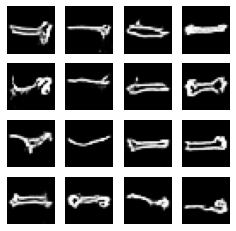

Time for epoch 75 is 211.87397360801697 sec


KeyboardInterrupt: ignored

In [32]:
%%time
train(train_dataset, EPOCHS)

## Displaying our generated images

---



In [38]:
def generate_images(model, test_input):
    # Notice `training` is set to False.
    # This is so all layers run in inference mode (batchnorm).
    predictions = model(test_input, training=False)

    fig = plt.figure(figsize=(8,8))

    for i in range(predictions.shape[0]):
        plt.subplot(8, 8, i+1)
        plt.imshow(predictions[i, :, :, 0] * -127.5 + 127.5, cmap='gray')
        plt.axis('off')

    plt.show()


Sample of 64 generated rabbit images

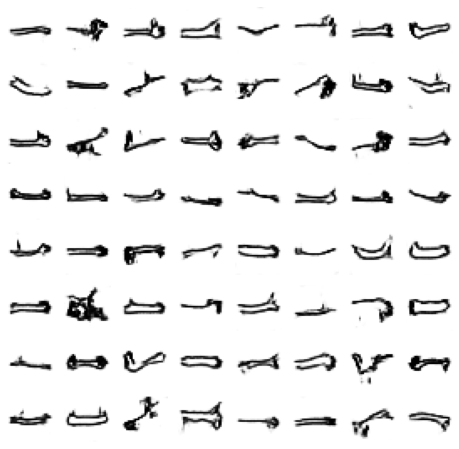

In [34]:
generate_images(generator, tf.random.normal([64, 100]))                                                                                                                                        

Sample of 64 original drawings

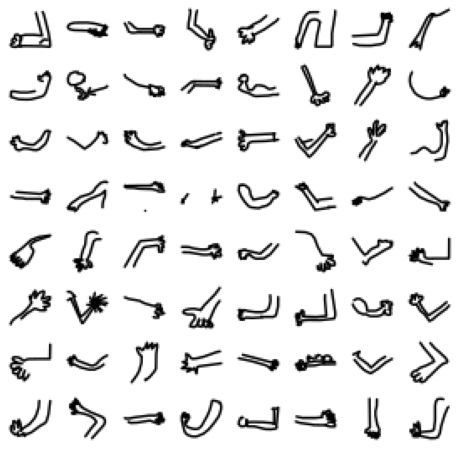

In [39]:
fig = plt.figure(figsize=(8,8))

for i in range(64):
    plt.subplot(8, 8, i+1)
    plt.imshow(train_images[10000+i, :, :, 0] * -127.5 + 127.5, cmap='gray')
    plt.axis('off')

plt.show()

In [42]:
anim_file = 'dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
  filenames = glob.glob(f'./images/{category}/*.png')
  filenames = sorted(filenames)
  for filename in filenames:
    image = imageio.imread(filename)
    writer.append_data(image)
  image = imageio.imread(filename)
  writer.append_data(image)

In [43]:
import tensorflow_docs.vis.embed as embed
embed.embed_file(anim_file)

Output hidden; open in https://colab.research.google.com to view.

## Some Notes

Generating different samples requires varying numbers of epochs. For example, a recognizible apple is generated after onyl 10 epochs, but generating a recognazible rabbit took more than 100 epochs. This may caused by diverse dataset. In case of apple, the most images contain a similar pattern, however a rabbit image sometimes contain a full rabbit, sometimes only the head. The generator model seems to consistently draw their common part, the rabbit ears. However, it will also be confused as to whether it should be drawing a head (round shape) or a body (elongated shape) The second reason might be that original drawings are sometimes incomplete : addind to the confusion between body and head, many of the original drawings seem to be missing facial features (eyes, nose, mouth), so our model has difficulties reproducing them.